In [2]:
import unipka
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np

calc = unipka.UnipKa(use_simple_smarts=False)

Get microstate distribution at target pH

In [3]:
mol = Chem.MolFromSmiles("[H]OC(=O)C([H])([H])N([H])[H]")
distribution_df = calc.get_distribution(mol, pH=2)
distribution_df

,charge,smiles,free_energy,ph_adjusted_free_energy,boltzmann_factor,population,mol,is_query_mol
0,1,[NH3+]CC(=O)O,-2.695786,-13.068690,473870.924305,6.506040e-01,<rdkit.Chem.rdchem.Mol object at 0x16907e340>,False
1,0,[NH3+]CC(=O)[O-],-12.443336,-12.443336,253555.113038,3.481200e-01,<rdkit.Chem.rdchem.Mol object at 0x16907e420>,False
2,1,NCC(O)=[OH+],3.542494,-6.830410,925.570177,1.270767e-03,<rdkit.Chem.rdchem.Mol object at 0x16907e490>,False
3,0,NCC(=O)O,-1.168798,-1.168798,3.218121,4.418339e-06,<rdkit.Chem.rdchem.Mol object at 0x16907e500>,True
4,2,[NH3+]CC(O)=[OH+],21.323997,0.578190,0.560913,7.701086e-07,<rdkit.Chem.rdchem.Mol object at 0x16907e570>,False
5,-1,NCC(=O)[O-],-5.467223,4.905681,0.007404,1.016592e-08,<rdkit.Chem.rdchem.Mol object at 0x16907e5e0>,False


You can pass in either a SMILES string or RDKit molecule. If the molecule has 3D coordinates, all enumerated microstates will be transplanted onto the reference, and the placement of any new hydrogens will be optimised. In the viewer below, we can see only the hydrogens coordinates differ between all microstates.

This is particularly useful when i) determing the correct protomer from a crystal structure, as only heavy atoms are visible, and ii) determing the correct protomer from a Boltz structure, as only heavy atoms are predicted.

In [5]:
!pip install py3Dmol
import py3Dmol

mol = Chem.MolFromSmiles("N1=CC=CC=C1NCCC")
AllChem.EmbedMolecule(mol)
distribution_df = calc.get_distribution(mol, pH=7.4)

viewer = py3Dmol.view(width=800, height=400, viewergrid=(1,2))

mols = distribution_df.mol.tolist()
for m in mols:
    mol1_block = Chem.MolToMolBlock(m)
    viewer.addModel(mol1_block, 'mol', viewer=(0,0))
    viewer.setStyle({'stick': {}}, viewer=(0,0))
                   # viewer=(0,0))

viewer.zoomTo(viewer=(0,0))
viewer


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

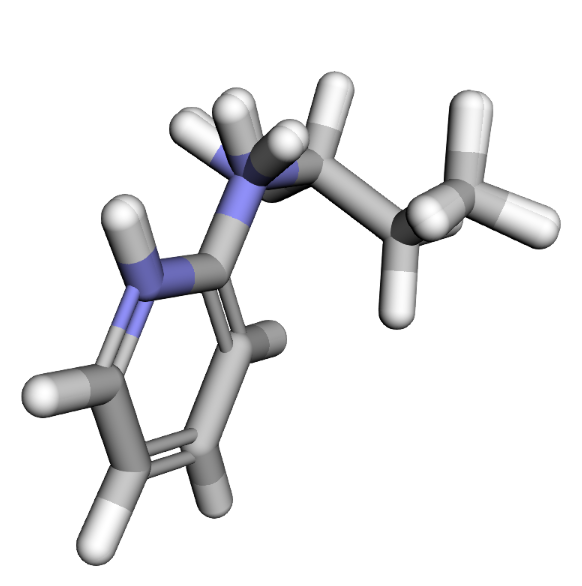

Calculate basic pKa from either manually or automatically enumerated microstates

In [7]:
pka_manual = calc.get_macro_pka_from_macrostates(acid_macrostate=["c1cc[nH+]cc1"], base_macrostate=["c1ccncc1"])
pka_auto = calc.get_basic_micro_pka("c1ccncc1", idx=3)
assert np.isclose(pka_manual,pka_auto)

acidic_pka_of_conjugate_acid = calc.get_acidic_micro_pka("c1cc[nH+]cc1", idx=3)

assert np.isclose(acidic_pka_of_conjugate_acid,pka_manual)
pka_manual

5.329479939022821

Get dominant microstate at a specific pH

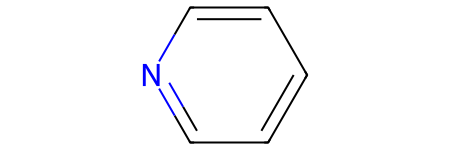

In [26]:
calc.get_dominant_microstate("N1=CC=CC=C1", pH=7.4)

Visualise the microstate distribution using the Jupyter widget

In [12]:
calc.draw_distribution("N1=CC=CC=C1NCCC", mode="jupyter")

Widget(data='[{"population": 8.572254681121816e-08, "smiles": "CCCNc1ccccn1", "charge": 0, "pH": 0.0, "name": …

Visualise the microstate distribution using the matplotlib

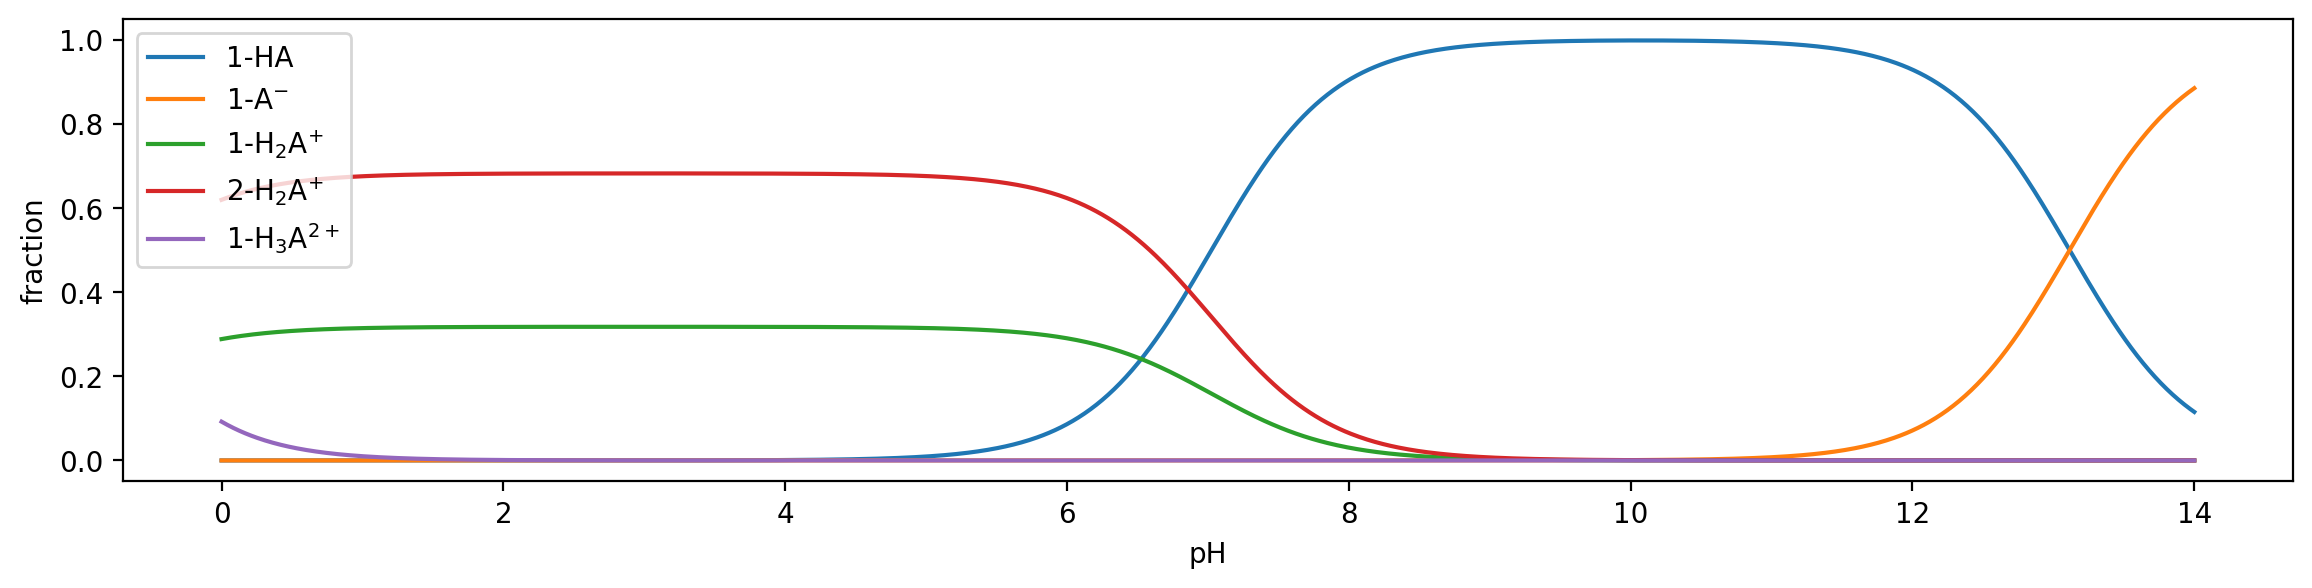

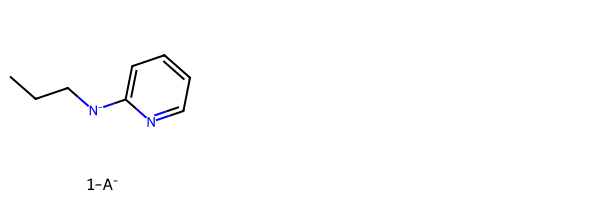

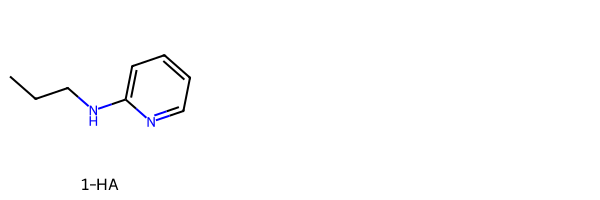

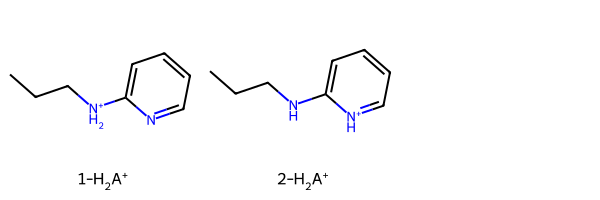

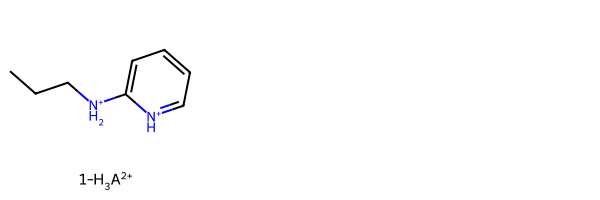

In [13]:
calc.draw_distribution("N1=CC=CC=C1NCCC", mode="matplotlib")

Calculate logD

In [18]:
calc.get_logd("N1=CC=CC=C1", pH=5.)

np.float64(0.5860744256723673)

Draw logD distribution

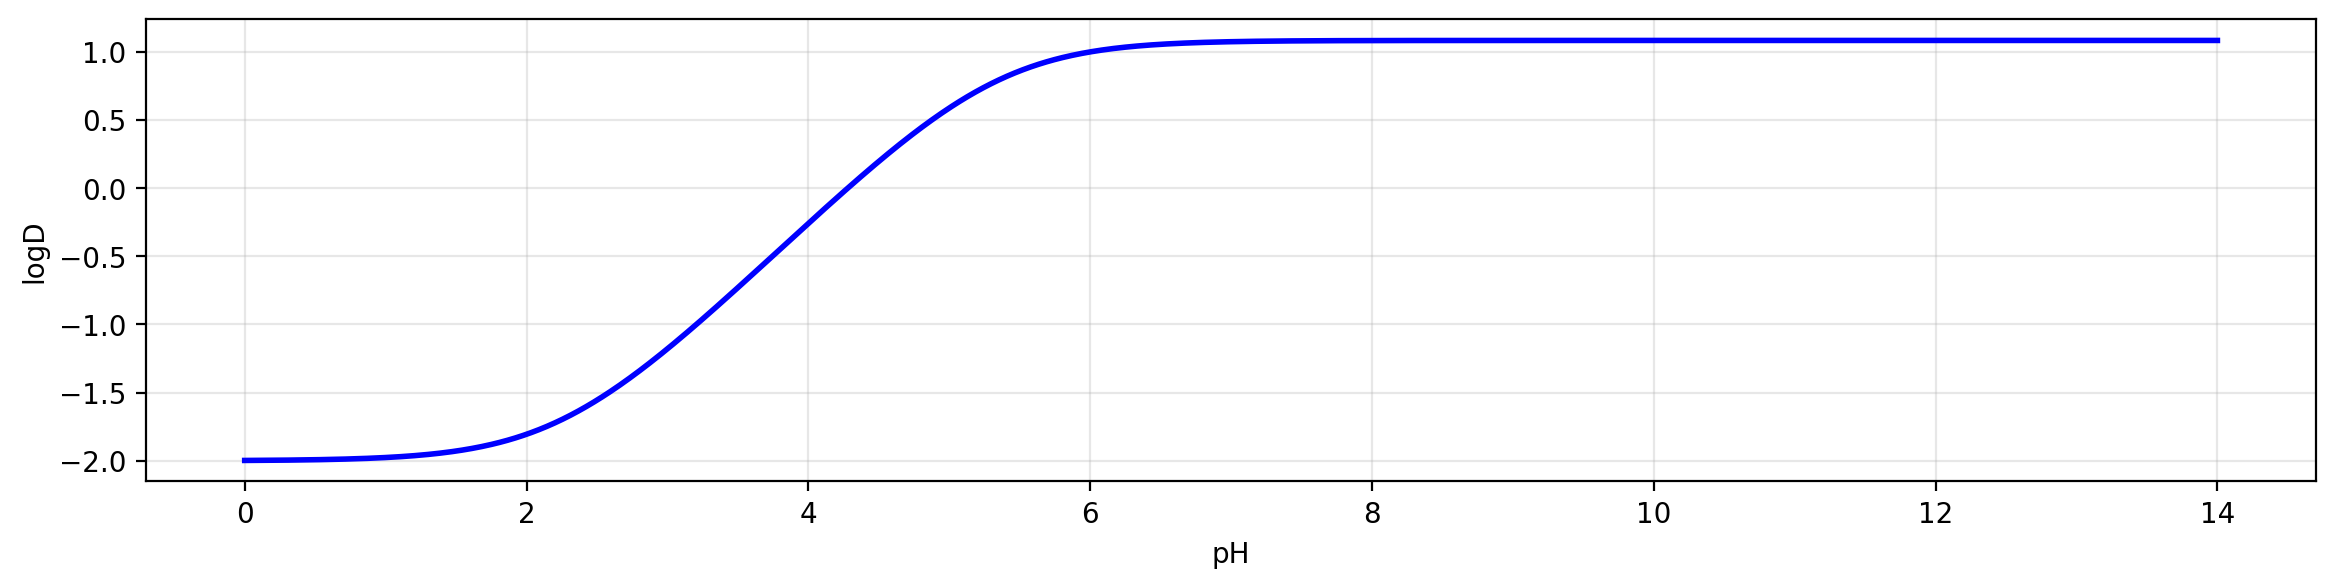

In [19]:
calc.draw_logd_distribution("N1=CC=CC=C1", mode="matplotlib")

Get the state penalty (the free energy required to shift the ionization equilibrium toward the neutral non-zwitterionic state). This can be used to calculate properties like following the methodology of [Rowan Sci and Lawrenz](https://chemrxiv.org/engage/api-gateway/chemrxiv/assets/orp/resource/item/68388349c1cb1ecda02ba65d/original/physics-informed-machine-learning-enables-rapid-macroscopic-p-ka-prediction.pdf).

In [43]:
state_penalty, reference_microstates_df  = calc.get_state_penalty("c1ccncc1", pH=5.)
print(state_penalty, "kcal/mol")
# Selects formally neutral microstates that minimize atom-centered charges, preferring non-zwitterionic forms over zwitterionic counterparts.
reference_microstates_df

0.6770291589615566 kcal/mol


,charge,smiles,free_energy,ph_adjusted_free_energy,boltzmann_factor,population,mol,is_query_mol,abs_formal_charge,abs_atoms_charges
0,0,c1ccncc1,-5.406792,-5.406792,222.915257,0.318938,<rdkit.Chem.rdchem.Mol object at 0x16968f530>,True,0,0


Predict the probability that Kpuu > 0.3

In [30]:
# Known drug with low CNS penetrance has a very low probability 
fexofenadine = "CC(C)(C1=CC=C(C=C1)C(CCCN2CCC(CC2)C(C3=CC=CC=C3)(C4=CC=CC=C4)O)O)C(=O)O"
prob = calc.predict_brain_penetrance(fexofenadine)
prob

np.float64(0.020897880941309194)

In [32]:
# The solvation energy (kcal/mol) is also very low.
G_solv = calc.get_solvation_energy(fexofenadine)

In [33]:
G_solv

np.float64(-20.176772252151867)